In [1]:
from fastai.text import *

In [2]:
PATH = Path('data/lm/')
WIKI_PATH=Path('data/japanese/ja.text8')

## Prepare Data

First we need to train a language model using the Japanese Wikipedia dump. We use a text8 format of this dump 

In [3]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import torch.optim as optim

from torch.autograd import Variable

In [4]:
import random

In [5]:
with WIKI_PATH.open() as f:
    wiki_text = f.read().split()

In [6]:
max_vocab = 60000
min_freq = 2

In [7]:
voc_cnt = collections.Counter(word for word in wiki_text)
itos = [o for o,c in voc_cnt.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')
#size = int(len(vocab)/2)
#vocab = vocab[:size]
#w2id = {w: i for i, w in enumerate(vocab)}
#ids = [[w2id[t] for t in sent] for sent in sents]


In [8]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [13]:
stoi['_pad_']

1

In [9]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    wiki_text, test_size=0.1, shuffle=False)

In [10]:
trn_lm = np.array([stoi[word] for word in trn_texts])
val_lm = np.array([stoi[word] for word in val_texts])

In [11]:
trn_lm.shape

(15210023,)

## Language model

In [15]:
wd=1e-7
bptt=70
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
vs = len(itos)

In [16]:
trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [17]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.4

In [18]:
em_sz,nh,nl = 200,500,3

In [19]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]

We set learning rates and fit our Japanese Wiki. We first run one epoch to get some initial weights

In [20]:
lr=1e-3
lrs = lr

In [21]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      5.178973   5.137773   0.262321  



[5.137772904607562, 0.2623211908862885]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [22]:
learner.unfreeze()

In [23]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.756341   4.808524   0.278797  



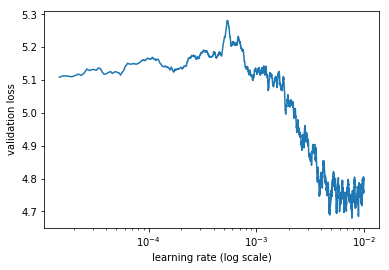

In [24]:
learner.sched.plot()

In [25]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                     
    0      4.78583    4.769363   0.283503  
    1      4.472815   4.466783   0.306745                     
    2      4.314674   4.321731   0.319315                     
 66%|██████▋   | 4501/6789 [16:21<08:19,  4.58it/s, loss=4.25]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    11     4.062575   4.073992   0.343652                     
    12     4.055865   4.067006   0.344424                     
    13     4.032004   4.061824   0.345126                     
    14     4.031999   4.05611    0.345817                     



[4.056109683288837, 0.3458165583382565]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [26]:
learner.save('lm_jawiki')

In [27]:
learner.save_encoder('lm_jawiki_enc')

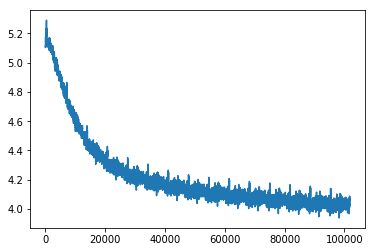

In [28]:
learner.sched.plot_loss()